<a href="https://colab.research.google.com/github/tinachung49/Portfolio/blob/main/Building_a_Historical_Valuation_Model_Using_Naive_Bayes_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quadratic Discriminant Analysis


In [ ]:
!pip install yfinance -q

In [ ]:
# 1. 載入所需套件
import yfinance as yf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal

In [ ]:
# 2. 數據處理
ticker = yf.Ticker("2330.TW")
hist_price = ticker.history(period="10y")
hist_price.index = hist_price.index.tz_localize(None)
financials = ticker.financials
eps = financials.loc['Diluted EPS']
total_revenue = financials.loc['Total Revenue']
shares = financials.loc['Diluted Average Shares']
sps = total_revenue / shares
hist_price['EPS'] = eps.reindex(hist_price.index, method='ffill')
hist_price['SPS'] = sps.reindex(hist_price.index, method='ffill')
hist_price.dropna(inplace=True)
hist_price['PE'] = hist_price['Close'] / hist_price['EPS']
hist_price['PS'] = hist_price['Close'] / hist_price['SPS']
data_df = hist_price[(hist_price['PE'] > 5) & (hist_price['PE'] < 50) &
                     (hist_price['PS'] > 1) & (hist_price['PS'] < 15)].copy()


In [ ]:
# 3. 數據標籤定義 (分類)
cheap_threshold = data_df['PE'].quantile(0.25)
expensive_threshold = data_df['PE'].quantile(0.75)
data_df['t'] = 3 # 3 = Fair
data_df.loc[data_df['PE'] < cheap_threshold, 't'] = 2 # 2 = Cheap
data_df.loc[data_df['PE'] > expensive_threshold, 't'] = 1 # 1 = Expensive
X = data_df[['PE', 'PS']].values
t = data_df['t'].values

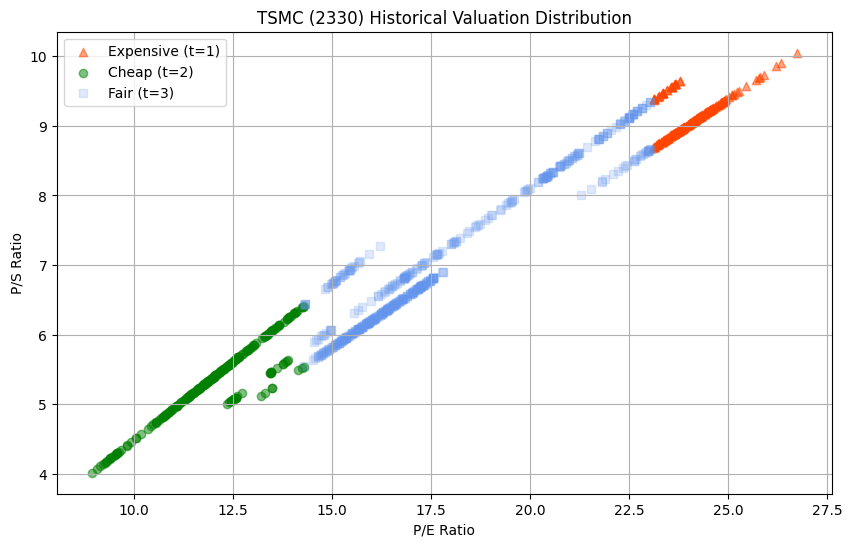

In [ ]:
# 4. 資料視覺化 (散佈圖)
X1 = X[t==1]; X2 = X[t==2]; X3 = X[t==3]
plt.figure(figsize=(10, 6))
plt.scatter(X1[:,0], X1[:,1], marker='^', label='Expensive (t=1)', color='orangered', alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], marker='o', label='Cheap (t=2)', color='green', alpha=0.5)
plt.scatter(X3[:,0], X3[:,1], marker='s', label='Fair (t=3)', color='cornflowerblue', alpha=0.2)
plt.xlabel("P/E Ratio")
plt.ylabel("P/S Ratio")
plt.title("TSMC (2330) Historical Valuation Distribution")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 5. 模型核心計算 (二次判別分析 QDA)
mu1 = np.mean(X1, axis=0); mu2 = np.mean(X2, axis=0); mu3 = np.mean(X3, axis=0)
Sig1 = np.cov(X1, rowvar=False); Sig2 = np.cov(X2, rowvar=False); Sig3 = np.cov(X3, rowvar=False)

In [ ]:
# 6. 建立決策邊界並繪圖
x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() + 1
x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() + 1
grid_x1, grid_x2 = np.meshgrid(np.linspace(x1_min, x1_max, 150),
                             np.linspace(x2_min, x2_max, 150))
pos = np.dstack((grid_x1, grid_x2))
Z1 = multivariate_normal(mu1, Sig1).pdf(pos)
Z2 = multivariate_normal(mu2, Sig2).pdf(pos)
Z3 = multivariate_normal(mu3, Sig3).pdf(pos)
prior1 = len(X1) / len(X); prior2 = len(X2) / len(X); prior3 = len(X3) / len(X)
denominator = Z1 * prior1 + Z2 * prior2 + Z3 * prior3
prob_class1 = (Z1 * prior1) / denominator
prob_class2 = (Z2 * prior2) / denominator


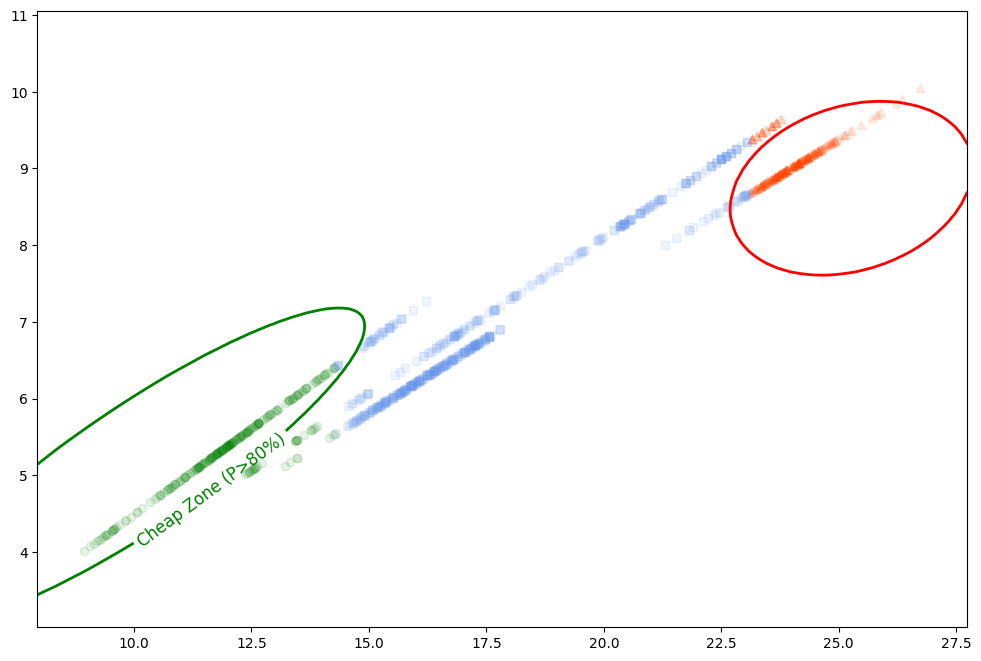

In [ ]:
# --- 開始繪製最終圖表 ---
plt.figure(figsize=(12, 8))
contour_expensive = plt.contour(grid_x1, grid_x2, prob_class1, levels=[0.8], colors='red', linewidths=2)
contour_cheap = plt.contour(grid_x1, grid_x2, prob_class2, levels=[0.8], colors='green', linewidths=2)
expensive_label = {0.8: 'Expensive Zone (P>80%)'}
cheap_label = {0.8: 'Cheap Zone (P>80%)'}
plt.clabel(contour_expensive, inline=True, fontsize=12, fmt=expensive_label)
plt.clabel(contour_cheap, inline=True, fontsize=12, fmt=cheap_label)
# 疊加歷史數據點
plt.scatter(X1[:,0], X1[:,1], marker='^', color='orangered', alpha=0.1)
plt.scatter(X2[:,0], X2[:,1], marker='o', color='green', alpha=0.1)
plt.scatter(X3[:,0], X3[:,1], marker='s', color='cornflowerblue', alpha=0.1)

Current Price: 1465.0
Latest EPS from financials: 45.25
Latest SPS from financials: 111.62157059998314
==> Calculated Current P/E: 32.38
==> Calculated Current P/S: 13.12
--- END DEBUGGING BLOCK ---



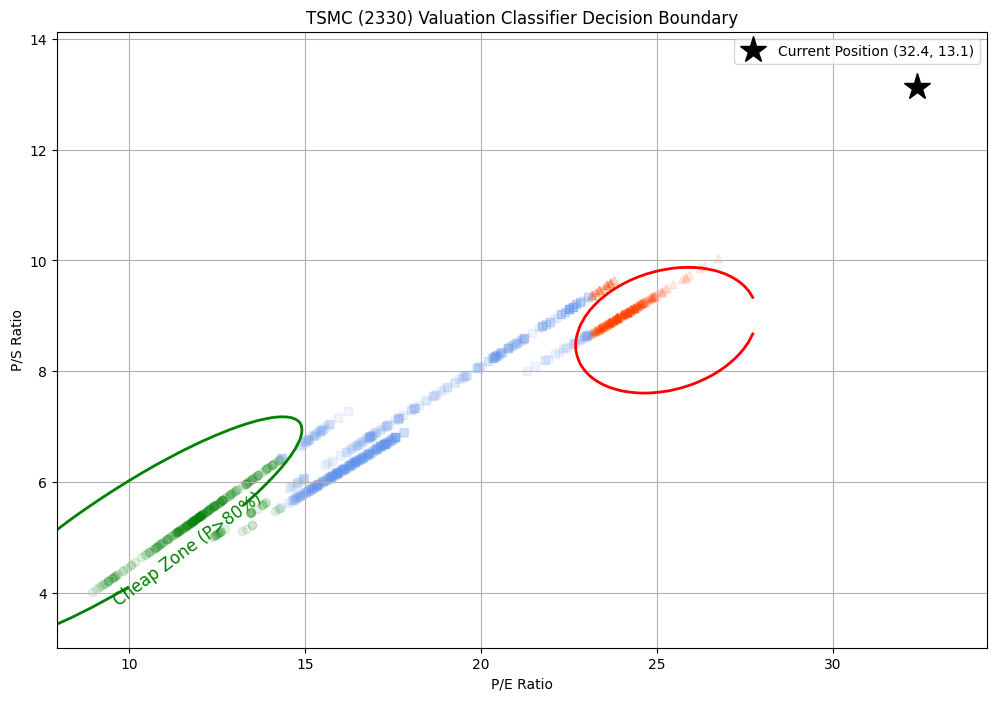

In [ ]:
plt.figure(figsize=(12, 8))
contour_expensive = plt.contour(grid_x1, grid_x2, prob_class1, levels=[0.8], colors='red', linewidths=2)
contour_cheap = plt.contour(grid_x1, grid_x2, prob_class2, levels=[0.8], colors='green', linewidths=2)
expensive_label = {0.8: 'Expensive Zone (P>80%)'}
cheap_label = {0.8: 'Cheap Zone (P>80%)'}
plt.clabel(contour_expensive, inline=True, fontsize=12, fmt=expensive_label)
plt.clabel(contour_cheap, inline=True, fontsize=12, fmt=cheap_label)
plt.scatter(X1[:,0], X1[:,1], marker='^', color='orangered', alpha=0.1)
plt.scatter(X2[:,0], X2[:,1], marker='o', color='green', alpha=0.1)
plt.scatter(X3[:,0], X3[:,1], marker='s', color='cornflowerblue', alpha=0.1)

#把今日的點放入圖中進行判斷
try:
    info = ticker.info
    current_price = info.get('regularMarketPrice') or info.get('previousClose')
    latest_eps = eps.iloc[0]
    latest_sps = sps.iloc[0]

    print(f"Current Price: {current_price}")
    print(f"Latest EPS from financials: {latest_eps}")
    print(f"Latest SPS from financials: {latest_sps}")

    if current_price and latest_eps and latest_sps:
        current_pe = current_price / latest_eps
        current_ps = current_price / latest_sps

        print(f"==> Calculated Current P/E: {current_pe:.2f}")
        print(f"==> Calculated Current P/S: {current_ps:.2f}")

        plt.plot(current_pe, current_ps,
                 marker='*', color='black', markersize=20, linestyle='None',
                 label=f'Current Position ({current_pe:.1f}, {current_ps:.1f})')

        # 1. 取得目前的 X, Y 軸範圍
        x_lim = list(plt.xlim())
        y_lim = list(plt.ylim())

        # 2. 檢查當前點是否在範圍外，如果是，則擴大範圍
        x_lim[0] = min(x_lim[0], current_pe - 2)   # 確保左邊界足夠
        x_lim[1] = max(x_lim[1], current_pe + 2)   # 確保右邊界足夠
        y_lim[0] = min(y_lim[0], current_ps - 1)   # 確保下邊界足夠
        y_lim[1] = max(y_lim[1], current_ps + 1)   # 確保上邊界足夠

        # 3. 設定新的圖表範圍
        plt.xlim(x_lim)
        plt.ylim(y_lim)

    else:
        print("--> WARNING: Failed to calculate. One of the values (price, eps, sps) is missing or zero.")

except Exception as e:
    print(f"--> ERROR: An exception occurred: {e}")

plt.xlabel("P/E Ratio")
plt.ylabel("P/S Ratio")
plt.title("TSMC (2330) Valuation Classifier Decision Boundary")
plt.grid(True)
plt.legend()
plt.show()